In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 25.2 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 908.7 kB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.5-cp310-cp310-linux_x86_64.whl size=293378 sha256=1a45a559a20e89b1761a64d70004120079e8b58e1109adfeccbbed60c24a77b9
  Stored in directory: /root/.cache/pip/wheels/06/80/9b/98db0d58349a2f5c09f8406789ade4270762f97b7d26f2fa22
Successfully built peewee


In [2]:
import yfinance as yf
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import pandas as pd

In [3]:
TSLA = yf.Ticker("TSLA")

In [4]:
TSLA = TSLA.history(period = "max")

In [5]:
# TSLA

In [6]:
TSLA.index = pd.to_datetime(TSLA.index)

<Axes: xlabel='Date'>

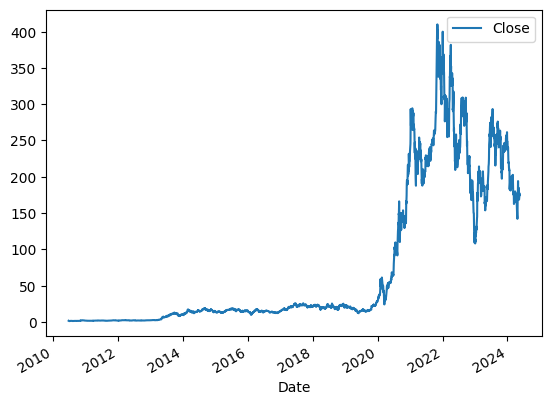

In [7]:
TSLA.plot.line(y="Close", use_index = True)

In [8]:
del TSLA ["Dividends"]

In [9]:
# TSLA

In [10]:
TSLA["Tomorrow"] = TSLA["Close"].shift(-1)

In [11]:
TSLA["Target"] = (TSLA["Tomorrow"] > TSLA["Close"]).astype(int)

In [12]:
TSLA = TSLA.loc["2019-01-01":].copy()

In [13]:
# from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100, min_samples_split = 100, random_state = 1)

train = TSLA.iloc[:-100]
test = TSLA.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [14]:
# from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index = test.index)
precision_score(test["Target"], preds)

0.43859649122807015

<Axes: xlabel='Date'>

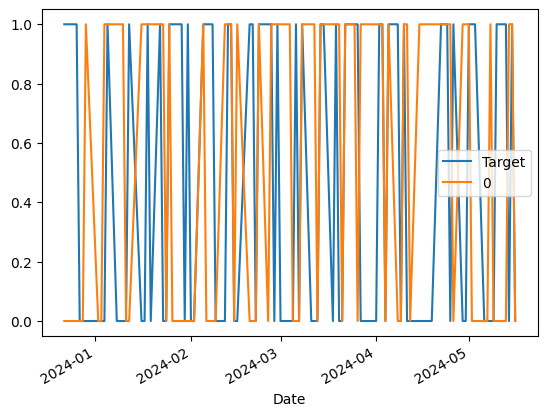

In [15]:
combined = pd.concat([test["Target"], preds], axis = 1)
combined.plot()

In [16]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [17]:
def backtest(data, model, predictors, start=600, step=50):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [18]:
predictions = backtest(TSLA, model, predictors)

In [19]:
predictions["Predictions"].value_counts()

Predictions
1    488
0    265
Name: count, dtype: int64

In [20]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5

In [21]:
predictions["Target"].value_counts()/predictions.shape[0]

Target
1    0.520584
0    0.479416
Name: count, dtype: float64

In [22]:
horizons = [2, 5, 60, 250, 500]
new_predictors = []

for horizon in horizons:
    rolling_averages = TSLA.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    TSLA[ratio_column] = TSLA["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    TSLA[trend_column] = TSLA.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors += [ratio_column, trend_column]

In [23]:
# TSLA

In [24]:
TSLA = TSLA.dropna()

In [25]:
TSLA

,Open,High,Low,Close,Volume,Stock Splits,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_500,Trend_500
Date,,,,,,,,,,,,,,,,,,
2020-12-24 00:00:00-05:00,214.330002,222.029999,213.666672,220.589996,68596800,0.0,221.229996,1,1.012074,2.0,1.004828,3.0,1.322009,34.0,2.339309,143.0,3.922157,274.0
2020-12-28 00:00:00-05:00,224.836670,227.133331,220.266663,221.229996,96835800,0.0,221.996674,1,1.001449,2.0,1.017418,3.0,1.316398,34.0,2.327012,143.0,3.905591,275.0
2020-12-29 00:00:00-05:00,220.333328,223.300003,218.333328,221.996674,68732400,0.0,231.593338,1,1.001730,2.0,1.015919,4.0,1.310094,35.0,2.316237,143.0,3.891534,275.0
2020-12-30 00:00:00-05:00,224.000000,232.199997,222.786667,231.593338,128538000,0.0,235.223328,1,1.021157,2.0,1.042521,5.0,1.354775,35.0,2.396159,143.0,4.030192,275.0
2020-12-31 00:00:00-05:00,233.330002,239.573334,230.373337,235.223328,148949700,0.0,243.256668,1,1.007776,2.0,1.040228,5.0,1.363088,36.0,2.413230,143.0,4.063258,275.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-09 00:00:00-04:00,175.009995,175.619995,171.369995,171.970001,65950300,0.0,168.470001,0,0.992068,0.0,0.965635,2.0,0.974061,28.0,0.774459,128.0,0.790704,255.0
2024-05-10 00:00:00-04:00,173.050003,173.059998,167.750000,168.470001,72627200,0.0,171.889999,1,0.989719,0.0,0.959691,1.0,0.956063,27.0,0.758691,128.0,0.775239,254.0
2024-05-13 00:00:00-04:00,170.000000,175.399994,169.000000,171.889999,67018900,0.0,177.550003,1,1.010048,1.0,0.993745,1.0,0.978114,27.0,0.774015,129.0,0.791484,255.0


In [26]:
model = RandomForestClassifier(n_estimators = 200, min_samples_split = 50, random_state = 1)

In [27]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index = test.index, name = "Predictions")
    combined = pd.concat([test["Target"], preds], axis = 1)
    
    return combined

In [28]:
predictions = backtest(TSLA, model, new_predictors)

In [29]:
predictions["Predictions"].value_counts()

Predictions
0.0    187
1.0     65
Name: count, dtype: int64

In [30]:
precision_score(predictions["Target"], predictions["Predictions"])

0.4461538461538462

In [31]:
predictions["Target"].value_counts() / predictions.shape[0]


Target
1    0.515873
0    0.484127
Name: count, dtype: float64

In [32]:
predictions

,Target,Predictions
Date,,
2023-05-16 00:00:00-04:00,1,0.0
2023-05-17 00:00:00-04:00,1,0.0
2023-05-18 00:00:00-04:00,1,0.0
2023-05-19 00:00:00-04:00,1,0.0
2023-05-22 00:00:00-04:00,0,0.0
...,...,...
2024-05-09 00:00:00-04:00,0,1.0
2024-05-10 00:00:00-04:00,1,1.0
2024-05-13 00:00:00-04:00,1,1.0


In [33]:
predictions.to_csv("Tesla stock predicition data.csv", index = "False")